# Sentiment Analysis model development (Twitter Airline dataset)
###For TrendSentimentAnalysis (tsa.)
Joyster Rodrigues | 2018487

**Instructions:**
Please download and store the dataset in the 'Files' section upon connecting to a runtime </br>
Download the dataset from [original source](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) or from [this link](https://drive.google.com/drive/folders/19AwC_aP13RTJBK7Xx2J0-Q50W14Nmam8?usp=share_link)

In [ ]:
# imports
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
df_tweets = pd.read_csv('./Tweets.csv')

In [ ]:
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df_data = df_tweets[['text','airline_sentiment']]

# Pre-processing dataset

In [ ]:
df_data = df_data[df_data.airline_sentiment != "neutral"]
df_data['text'] = df_data['text'].apply(lambda x: x.lower())
df_data['text'] = df_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

<ipython-input-5-167caa7fa367>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['text'] = df_data['text'].apply(lambda x: x.lower())
<ipython-input-5-167caa7fa367>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['text'] = df_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


# Tokenising and Vectorising

In [ ]:
sentences = df_data['text'].values
max_words = 2000
max_length = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(sentences)
x_seq = tokenizer.texts_to_sequences(sentences)
x_pad = pad_sequences(x_seq, maxlen=max_length)

# Model architecture

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length = max_length))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           256000    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 1)                 197       
                                                                 
Total params: 510,997
Trainable params: 510,997
Non-trainable params: 0
_________________________________________________________________


# training model

In [ ]:
y_converted = []
for item in df_data['airline_sentiment']:
  if item == 'positive':
    y_converted.append(1)
  else:
    y_converted.append(0)


In [ ]:
print(y_converted[:5])

[1, 0, 0, 0, 1]


In [ ]:
print(df_data['airline_sentiment'].head(5))

1    positive
3    negative
4    negative
5    negative
6    positive
Name: airline_sentiment, dtype: object


In [ ]:
y_converted = np.array(y_converted)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pad,y_converted, test_size = 0.30, random_state = 42)


In [ ]:
batch = 512
history = model.fit(x_train, 
                    y_train, 
                    epochs = 10, 
                    batch_size=batch, 
                    validation_data=(x_test, y_test))

Epoch 1/10
16/16 [==============================] - 15s 494ms/step - loss: 0.5644 - accuracy: 0.7764 - val_loss: 0.4442 - val_accuracy: 0.8002
Epoch 2/10
16/16 [==============================] - 5s 323ms/step - loss: 0.3996 - accuracy: 0.8199 - val_loss: 0.3459 - val_accuracy: 0.8539
Epoch 3/10
16/16 [==============================] - 7s 421ms/step - loss: 0.3186 - accuracy: 0.8614 - val_loss: 0.2819 - val_accuracy: 0.8906
Epoch 4/10
16/16 [==============================] - 5s 303ms/step - loss: 0.2414 - accuracy: 0.9081 - val_loss: 0.2275 - val_accuracy: 0.9191
Epoch 5/10
16/16 [==============================] - 7s 431ms/step - loss: 0.1888 - accuracy: 0.9273 - val_loss: 0.2121 - val_accuracy: 0.9197
Epoch 6/10
16/16 [==============================] - 5s 329ms/step - loss: 0.1570 - accuracy: 0.9405 - val_loss: 0.2041 - val_accuracy: 0.9249
Epoch 7/10
16/16 [==============================] - 7s 435ms/step - loss: 0.1326 - accuracy: 0.9504 - val_loss: 0.1967 - val_accuracy: 0.9243
Epoch

# test model

In [ ]:
test = ['this is just a sentence',
        'this is a bad day not liking it', 
        'this is a great amazing day wow', 
        "I'm having a great day today!", 
        "I wish I never left the bed, terrible weather today!",
        'i would hate it if it rains today',
        'i dislike icecream, it gives me shivers',
        'what can i say, today was the best day of mu life',
        'very interesting sentence, so much negative potential'
        ]

In [ ]:
test_vect = tokenizer.texts_to_sequences(test)
test_pad = pad_sequences(test_vect, maxlen=max_length)

In [ ]:
results = model.predict(test_pad)

1/1 [==============================] - 0s 262ms/step


In [ ]:
print(results)

[[0.49909958]
 [0.01775144]
 [0.99340993]
 [0.97335386]
 [0.16152762]
 [0.15391813]
 [0.20584947]
 [0.9383695 ]
 [0.7839796 ]]


# save model for tsa

In [ ]:
model.save('twitter_airline_model3.h5')

In [ ]:
import pickle
with open('airline_senti_tokenzier2.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# model evaluation

## confusion matrix

In [ ]:
def conf_matrix(model):
  y_true = y_test
  y_pred = model.predict(x_test)

  new_pred = []
  for x in y_pred:
    if x < 0.5:
      new_pred.append(0)
    else:
      new_pred.append(1)

  conf_matrix = confusion_matrix(y_true, new_pred)

  # confusion matrix
  print(conf_matrix)

  sns.heatmap(conf_matrix, cmap='YlGn', annot=True, fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [ ]:
def class_report(model):
    y_true = y_test
    y_pred = model.predict(x_test)
    
    new_pred = []
    for x in y_pred:
      if x < 0.5:
        new_pred.append(0)
      else:
        new_pred.append(1)

    print(classification_report(y_true, new_pred))

109/109 [==============================] - 2s 18ms/step
[[2660  111]
 [ 150  542]]


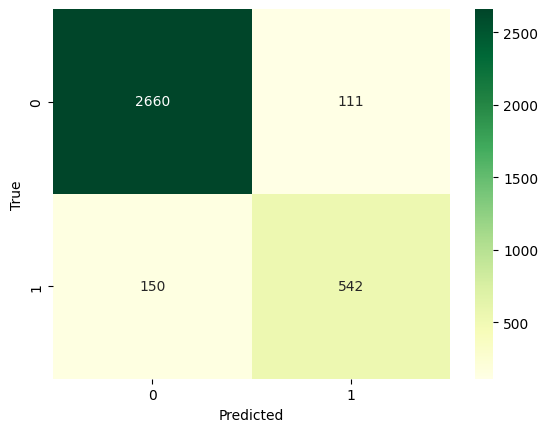

In [ ]:
conf_matrix(model)

In [ ]:
class_report(model)

109/109 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2771
           1       0.83      0.78      0.81       692

    accuracy                           0.92      3463
   macro avg       0.89      0.87      0.88      3463
weighted avg       0.92      0.92      0.92      3463



In [ ]:
def create_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()


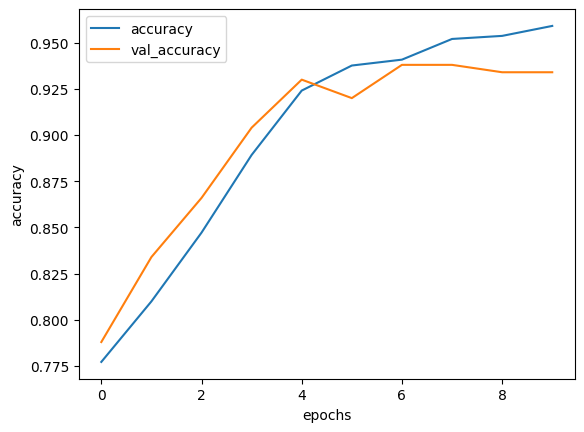

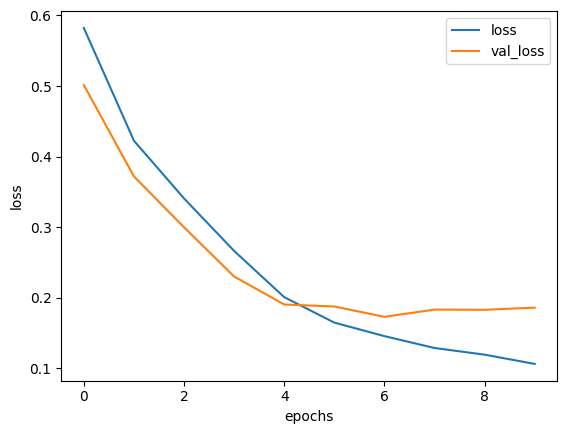

In [ ]:
create_graph(history, 'accuracy')
create_graph(history, 'loss')

# Citation

Eight, F. (2019) Twitter us airline sentiment, Kaggle. Available at: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment (Accessed: January 2023). 